In [35]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
from matplotlib import rc
from matplotlib.ticker import LogFormatter
from math import log, exp, sqrt, pow

plt.rc('text', usetex=True)
plt.rc('font', family='sans-serif')

#### the efficiency of XENON1T

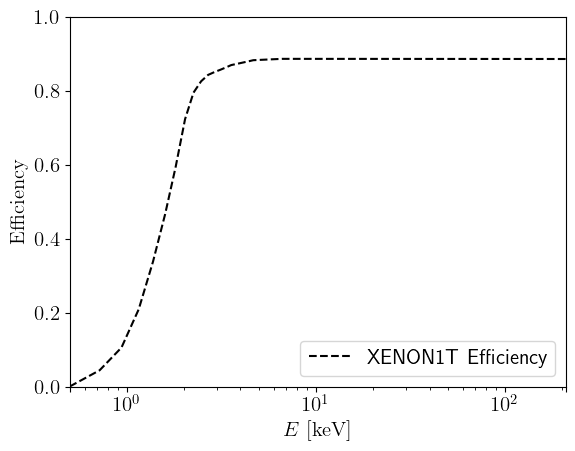

In [36]:
# data_path = "/home/yuangw/Desktop/chameleons/2103.15834/data/"
data_path = "/Users/yuangw/Desktop/chameleons/2103.15834/data/"
fE = data_path+'efficiency.csv'
fs = data_path+'sigmaevsE.txt'

# Define the efficiency of the XENON1T detector vs energy in keV
# See the XENON paper 2006.09721 Fig.2 
ekeV, eff = np.loadtxt(fE, dtype='f8', delimiter = ',', usecols=(0,1), unpack=True)
epsilon   = interpolate.interp1d(ekeV, eff, fill_value=(0.,0.89), bounds_error=False)

ekeV0 = np.linspace(0.5, 220, 1000)
plt.plot(ekeV0, epsilon(ekeV0), color='black', linestyle='--', label=r'XENON1T Efficiency')
plt.xlabel(r'$E~ {\rm [keV]}$', fontsize=15)
plt.ylabel(r'${\rm Efficiency}$', fontsize=15)
plt.xlim(0.5, 210)
plt.ylim(0, 1)
plt.xscale('log')
plt.xticks([0.5, 1, 10, 100, 210], fontsize=15)
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1], fontsize=15)
plt.legend(fontsize=15, loc='lower right')
plt.savefig('plots/efficiency.pdf', dpi=300, bbox_inches='tight')
plt.show()

#### energy resolution

* For the energy resolution of XENON1T, its theoretical spectra were smeared using a Gaussian distribution with energy-dependent width, which was determined using an empirical fit of mono-energetic peaks as described by:
$$\sigma(E) = a\cdot \sqrt{E} + b\cdot E ,$$
with $a=(0.310\pm 0.004) \sqrt{\rm keV}$ and $b=0.0037\pm 0.0003$.
* we can convolve the theoretical spectrum using a Gaussian kernel that varies with energy. Since $\sigma (E)$ is energy-dependent, this is a non-stationary convolution, so we need to smear point by point.

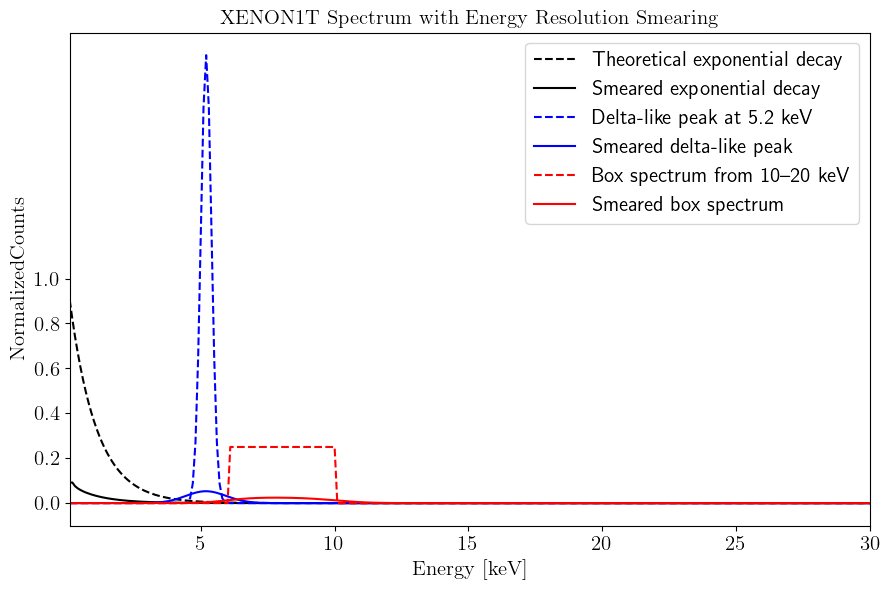

In [39]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

# === Energy resolution function (XENON1T empirical model) ===
def sigma_E(E):
    a = 0.310  # sqrt(keV)
    b = 0.0037
    return a * np.sqrt(E) + b * E  # in keV

# === Theoretical spectra ===
def exponential_spectrum(E):
    return np.exp(-E / 1.0)

def gaussian_peak(E_vals, E0=5.2, sigma0=0.1, amplitude=1.0):
    norm_factor = amplitude / (sigma0 * np.sqrt(2 * np.pi))
    return norm_factor * np.exp(-0.5 * ((E_vals - E0) / sigma0)**2)

def box_spectrum(E_vals, E_min=7, E_max=10, amplitude=1.0):
    spec = np.zeros_like(E_vals)
    mask = (E_vals >= E_min) & (E_vals <= E_max)
    spec[mask] = amplitude / (E_max - E_min)  # unit area
    return spec

# === Normalize spectrum to unit area (optional) ===
def normalize(spec, E_vals):
    return spec / np.trapz(spec, E_vals)

# === Smearing function: energy-dependent Gaussian convolution ===
def smeared_spectrum(E_vals, spec, sigma_func, normalize_result=False):
    smeared = np.zeros_like(E_vals)
    dE = E_vals[1] - E_vals[0]

    for i, E0 in enumerate(E_vals):
        sigma = sigma_func(E0)
        kernel = norm.pdf(E_vals, loc=E0, scale=sigma)
        kernel /= np.sum(kernel)  # normalize kernel
        smeared += spec[i] * kernel * dE

    if normalize_result:
        smeared = normalize(smeared, E_vals)

    return smeared


E_vals = np.linspace(0.1, 30, 300)  # energy values in keV

# === Generate theoretical spectra ===
spec_exp = exponential_spectrum(E_vals)
spec_delta = gaussian_peak(E_vals, E0=5.2, sigma0=0.2)  
spec_box = box_spectrum(E_vals, E_min=6, E_max=10)

# === Smear spectra using detector resolution ===
smeared_exp = smeared_spectrum(E_vals, spec_exp, sigma_E)
smeared_delta = smeared_spectrum(E_vals, spec_delta, sigma_E)
smeared_box = smeared_spectrum(E_vals, spec_box, sigma_E)

# === Plotting ===
plt.figure(figsize=(9, 6))

plt.plot(E_vals, spec_exp, color='black', linestyle='--', label='Theoretical exponential decay')
plt.plot(E_vals, smeared_exp, color='black', linestyle='-', label='Smeared exponential decay')

plt.plot(E_vals, spec_delta, color='blue', linestyle='--', label='Delta-like peak at 5.2 keV')
plt.plot(E_vals, smeared_delta, color='blue', linestyle='-', label='Smeared delta-like peak')

plt.plot(E_vals, spec_box, color='red', linestyle='--', label='Box spectrum from 10–20 keV')
plt.plot(E_vals, smeared_box, color='red', linestyle='-', label='Smeared box spectrum')

plt.xlabel(r'${\rm Energy~[keV]}$', fontsize=15)
plt.ylabel(r'${\rm Normalized Counts}$', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1], fontsize=15)
plt.title(r'${\rm XENON1T~Spectrum~with~Energy~Resolution~Smearing}$', fontsize=15)
plt.xlim(0.1, 30)
plt.legend(loc='best', fontsize=15)
plt.tight_layout()
plt.savefig('plots/smeared_spectra.pdf', bbox_inches='tight')  
plt.show()


#### the background and measurements

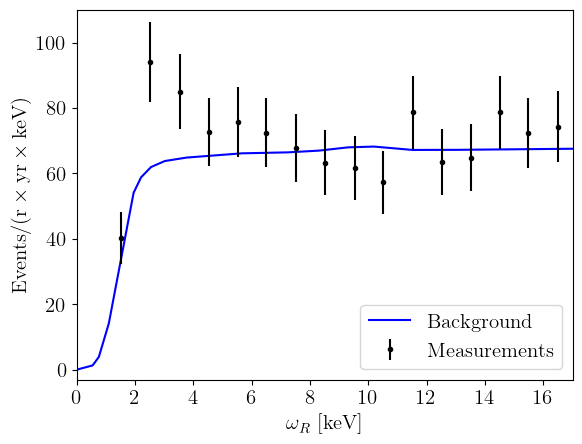

In [38]:
fC = data_path+'Central.csv'
fL = data_path+'Lower.csv'
fU = data_path+'Upper.csv'
fS = data_path+'Signal.csv'

## Read the XENON1T data and define the central deviation
xd, yC = np.loadtxt(fC, dtype='f8', delimiter = ',', usecols=(0,1), unpack=True)
xd, yL = np.loadtxt(fL, dtype='f8', delimiter = ',', usecols=(0,1), unpack=True)
xd, yU = np.loadtxt(fU, dtype='f8', delimiter = ',', usecols=(0,1), unpack=True)
sigD = (yU-yL)/2.

# Define the function giving the XENON1T background vs energy in keV
enb, backb = np.loadtxt(fS, dtype='f8', delimiter = ',', usecols=(0,1), unpack=True)
back = interpolate.interp1d(enb, backb, fill_value=(0.0, 0.0), bounds_error=False)

engb = np.linspace(0, 17, 1000)
plt.plot(engb, back(engb), color='blue', linestyle='-', label=r'${\rm Background}$')
plt.errorbar(xd, yC, yerr=sigD, xerr=None, fmt='.k', label=r'${\rm Measurements}$')
plt.xlabel(r'$\omega_R~{\rm [keV]}$', fontsize=15)
plt.ylabel(r'${\rm Events}/({\rm r}\times {\rm yr} \times {\rm keV})$', fontsize=15)
plt.xlim(0, 17)
plt.ylim(-3, 110)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15, loc='lower right')
plt.savefig('plots/XENON1T_data.pdf', dpi=300, bbox_inches='tight')
plt.show()